## Astronomy 406 "Computational Astrophysics" (Fall 2015)

### Week 3: Numerical Integration

<b>Reading:</b> notes below, as well as [$\S$4.0-4.5](https://umich.instructure.com/files/2392519/download?download_frd=1) of <i>Numerical Recipes</i>.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

The concept of numerical integration is simple: evaluate the area under the curve traced by the input function $f(x)$.  The simplest approach is to divide the range of integration $a < x < b$ into equal intervals $x_i = a + i*h$ (with $x_{n-1} = b$) and approximate the function by a constant value within the interval:
$\int_a^b f(x) dx \approx \sum_i \int_{x_i}^{x_{i+1}} f(x_i) dx = h \sum_i f(x_i)$.

A more accurate formula is to approximate $f(x)$ by a linear function, going from $f(x_i)$ at $x_i$ to $f(x_{i+1})$ at $x_{i+1}$:
$\int_a^b f(x) dx \approx \sum_i \int_{x_i}^{x_{i+1}} \left[ f(x_i) + (f(x_{i+1})-f(x_i)) {x-x_i \over x_{i+1}-x_i} \right] dx = h \sum_i {1\over 2} [f(x_i) + f(x_{i+1})]$.

It is called a trapeziodal rule and is the most basic acceptable way to evaluate an integral numerically.

An even better, higher-order scheme is called Simpson's rule.  It is described in $\S$4.1.1 of NR, which you can read in the Reference files on Canvas.

The most important question is how to choose the step $h$.  In order to achieve particular accuracy, which is specified by the user, we need to employ some form of accuracy control.  One of the best is again Richardson's method!  We can take it almost as it is written above.  A specific implementation for integration is given in $\S$4.3 of NR.

Scipy has a general integration routine <b>scipy.integrate.quad</b>, where you can specify different integration methods.

Let's look at a simple example.

In [2]:
mu = 3.
sig2 = 1.

# Gaussian function
def fg(x):    
    return np.exp(-(x-mu)**2 / sig2/2.)/np.sqrt(2.*np.pi*sig2)

In [3]:
def simple_int(f, a, b, n): #Rectangular
    y = 0.
    h = (b-a)/n
    for i in range(n):
        y += h*f(a+i*h)
    return y

def trap_int(f, a, b, n): #Trapezoidal
    y = 0.
    h = (b - a) / n
    for i in range(n - 1):
        y += h/2 * (f(a + i*h) + f(a + (i + 1) * h))
    return y

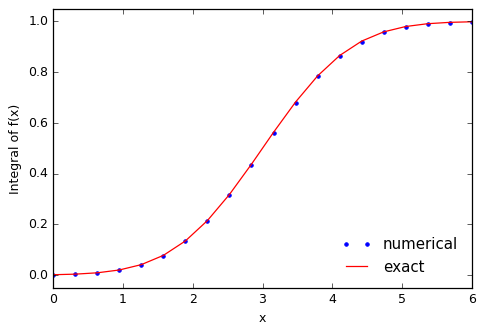

In [8]:
a = 0.0
x = np.linspace(0,6,20)
yint = simple_int(fg, a, x, 1000)
ytrap = trap_int(fg, a, x, 1000)

from scipy import special
yexa = (1.+special.erf((x-mu)/np.sqrt(2.*sig2)))/2.

plt.xlabel('x')
plt.ylabel('Integral of f(x)')
plt.xlim(0, 6)
plt.ylim(-0.05, 1.05)
plt.plot(x, yint, 'b.', label='numerical')
plt.plot(x, yexa, 'r-', label='exact')
plt.legend(frameon=False, loc=4)

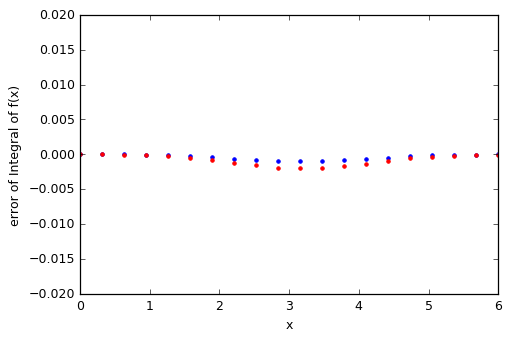

In [10]:
plt.xlabel('x')
plt.ylabel('error of Integral of f(x)')
plt.xlim(0, 6)
plt.ylim(-0.02, .02)
plt.plot(x, yint-yexa, '.')
plt.plot(x, ytrap - yexa, 'r.')

#### Improper integrals

So far we have discussed numerical integration of a well-behaved function in a finite interval [a,b].  Often we have to deal with more complex situations.  For example, the integrand may reach infinity at the integration bounds, and therefore cannot be evaluated there, even though the integral itself may be finite.  Another example is when one or both integration bounds themselves are infinite, and therefore, choosing an integration step $h$ is difficult.  Such cases are called <i>improper integrals</i> and require special treatment.

In the first case, if the integrand cannot be evaluated at the integration boundary, we can switch from a closed interval to an open interval.  NR $\S$4.4 gives an example of the Second Euler-Maclaurin summation formula:
$\int_{x_0}^{x_{n-1}} f(x) dx \approx h \sum_{i=0}^{n-2} f(x_{i+1/2})$.
Here we evaluate the function in the middle of each step, at $x_0 + h/2, x_0 + 3h/2$, etc.
  
A better way is to implement Richardson's method, similarly to the closed scheme in HW2. 
  
Below is a simple example, for $f(x) = {1 \over \pi \sqrt{x} (1+x)}$.  The integral from 0 to infinity exists and equals unity.  However, the function $f(x)$ diverges at $x=0$ and falls off slowly at $x \gg 1$.  Let's first look at the function, and then integrate it from 0 to 5 with a thousand steps.

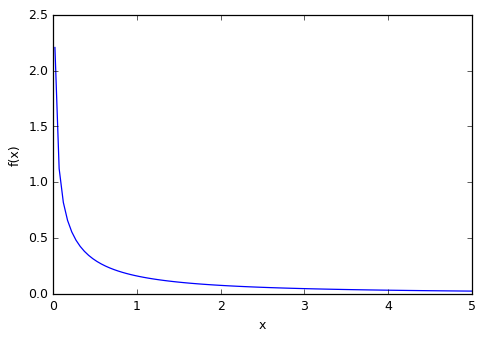

In [11]:
def f1(x):
    return 1./np.pi/np.sqrt(x)/(1+x)

x = np.linspace(0.02, 5, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, f1(x), '-')

In [ ]:
def open_int(f, a, b, n): #Euler-Maclaurin technique
    y = 0.
    h = (b-a)/n
    for i in range(n-1):
        y += h*f(a+(i+0.5)*h)
    return y

print open_int(f1, 0., 1000., 100000)

Scipy's general integration routine <b>scipy.integrate.quad</b> can deal with such cases, although all details are hidden inside their "black box".

In [ ]:
s = integrate.quad(f1, 0., 100.)
print 'quad =', s[0], 'estimated error =', s[1]

As we can see, the value of the integral is different from that calculated by our simple routine above, by a much larger amount than the estimated error.  Adaptive control of accuracy, such as that provided by Richardson's method, is really important here!

#### Variable transformation

Let's now consider the case of infinite integration range, $\int_{0}^{\infty} f(x) dx$.  A simple routine would do poorly here, also necessarily requires a fixed upper integration limit:

In [ ]:
int = open_int(f1, 0., 100., 1000)
print 'simple routine =', int

s = integrate.quad(f1, 0, np.inf)
print 'quad =', s[0], 'estimated error =', s[1]

The analytical answer is indeed 1, so our <b>open_int</b> underestimates by 10-15%.

A very useful trick in this case is to transform the integration variable, from $x$ to $t(x)$, such that the new variable $t$ has a finite range:
$\int f(x) dx = \int f(x(t)) {dx \over dt} dt$.

One possible transformation is $t = (x-1)/(x+1)$.  The inverse is $x(t) = (1+t)/(1-t)$.  It converts the range $x \in [0,\infty)$ to $t \in [-1,1)$.  <i>Numerical Recipes</i> provides other examples of efficient variable transformations that speed up convergence of the integral.  See their $\S$4.5.

Even our simple routine performs better with a transformed variable:

In [ ]:
def f2(t):
    x = (1.+t)/(1.-t)
    return f1(x)*2./(1-t)**2

int = open_int(f2, -1., 1., 1000)
print 'simple routine transformed =', int

s = integrate.quad(f2, -1., 1.)
print 'quad transformed =', s[0], 'estimated error =', s[1]

If the integration limits go from negative to positive ($a<0, b>0$), including infinities, it is often useful to break the integral into two pieces:
$\int_a^b f(x) dx = \int_a^0 f(x) dx + \int_0^b f(x) dx$,
and then do variable transformation on each interval separately.

If you have a symmetric function, $f(x) = f(-x)$, then you can simplify integrals like this:
$\int_{-a}^a f(x) dx = 2 \int_0^a f(x) dx$.

In practice, you can use SciPy's sophisticated <b>quad</b> routine for all your needs.  What you need to know is how to transform your function or the integration variable, so that the routine can do a good job. The more you simplify your integral analytically, the more accurate will be the numerical result.

<b>Exercise 1:</b> Use the transformation $x = e^t$ to evaluate the integral $\int_0^\infty f_1(x) dx$, using the simple trapezoidal rule.  Integrate over the range $t \in (-90,90)$.  Output the value of the integral as a function of number of steps 10, 20, 40, 80, ..., until the answer converges to machine precision.  Make appropriate plots.

<b>Exercise 2:</b> If you succeed with Exercise 1, try another transformation $x = \exp{(\pi \sinh(t))}$ and integrate over $t \in (-4,4)$.  Compare the number of steps required to reach the same accuracy with Exercise 1.  
[Hyperbolic function $\sinh(t) \equiv (e^t - e^{-t})/2$.]

7


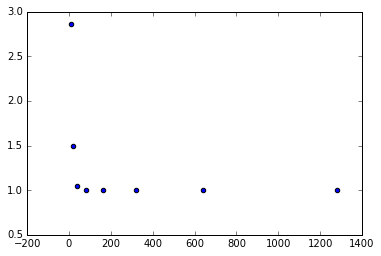

In [9]:
#Exercise 1
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def trapezoidal(f, a, b, n):
    h = (b - a) / n
    xRange = np.arange(a, b, h)
    mySum = f(a) + f(b)
    for x in xRange[1:]:
        mySum += f(x) * 2. * h
    return 0.5 * mySum

def f1(x):
    return 1./np.pi/np.sqrt(x)/(1+x)

def f2(t):
    x = np.exp(t)
    return f1(x) * x

n = 10
nList = [n]
diff = 1.
counter = 0
intList = [trapezoidal(f2, -90., 90., n)]
while (diff >= 1e-15) & (counter < 500):
    n *= 2.
    nList.append(n)
    intList.append(trapezoidal(f2, -90., 90., n))
    diff = np.fabs(intList[-1] - intList[-2])
    counter += 1

print counter
plt.scatter(nList, intList)

### Homework 2 (due Tuesday, Sep 27, 9am)

Write a routine for numerical integration of an input function $f(x)$ to a user-specified accuracy $\epsilon$ using trapeziodal rule with Richardson's method.  Calculate the integral of the Gaussian function $fg(x)$ above on a grid of values $x = 0, 0.1, 0.2, ..., 6$, with $\epsilon = 10^{-10}$, and plot them as points.  Overplot the exact solution and check your accuracy.  Then calculate and plot the error $Int(numerical)-Int(exact)$.  Does it agree with the specified $\epsilon$?

Int(exact) = np.special.erf()